In [14]:
%conda install numpy
%conda install pandas
%conda install matplotlib

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Pikam\anaconda3\envs\regression

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.11.0              |     pyhd3eb1b0_0          12 KB
    jpeg-9e                    |       h2bbff1b_0         292 KB
    kiwisolver-1.3.2           |   py39hd77b12b_0          56 KB
    libwebp-1.2.2              |       h2bbff1b_0         658 KB
    matplotlib-3.5.1           |   py39haa95532_1          29 KB
    matplotlib-base-3.5.1      |   py39hd77b12b_1     

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## data

I used the market history dataset of Xindian District, New Taipei City, Taiwan (https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set).

The model predict "house price of unit area" from "distance to the nearest MRT station".

All data were split into training data of size 334 and test data of size 80 for the experiment.

In [184]:
_df = pd.read_csv('data.csv')
_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [185]:
x = _df['X3 distance to the nearest MRT station']
y = _df['Y house price of unit area']

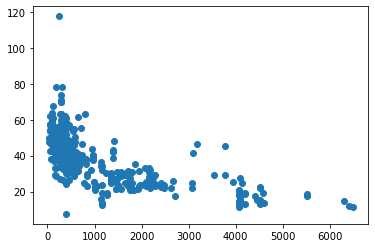

In [186]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)

test data and train data

In [187]:
df_size = len(_df)
np.random.seed(0)
rand_ids = np.random.choice(df_size, df_size, replace=False)
train_size = 334
train_ids = rand_ids[:train_size]
test_ids = rand_ids[train_size:]

train_x = x[train_ids]
test_x = x[test_ids]
train_y = y[train_ids]
test_y = y[test_ids]

## Polynomial Curve Fitting
### 1-order
$$
\hat{y} = w_0 + w_1x
$$
Loss(least squares error)：
$$
L = \frac{1}{2}\sum_{n=1}^{N} \{\hat{y_n}−y_n\}^2
$$
By solving $\frac{\partial L}{\partial w_0} = 0, \frac{\partial L}{\partial w_1} = 0,$
$$
\begin{split}
    w_0 &= \bar{y} - w_1\bar{x} \\
    w_1 &= \frac{\sum_{n=1}^{N}\{(x_n-\bar{x})(y_n-\bar{y})\}}{\sum_{n=1}^{N}(x_n-\bar{x})^2}
\end{split}
$$
※$\bar{x}$ is mean of $x$.

In [188]:
def poly_1(x, y):
    x_bar = x.mean()
    y_bar = y.mean()
    w_1 = np.dot(x - x_bar, y - y_bar) / ((x - x_bar)**2).sum()
    w_0 = y_bar - w_1*x_bar
    return w_0, w_1

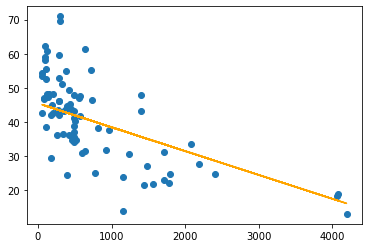

In [189]:
w_0, w_1 = poly_1(train_x, train_y)
predict_y = w_0 + w_1*test_x

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(test_x, test_y)
ax.plot(test_x, predict_y, 'orange')

### Model Ealuation by RMSE
$$
RMSE = \sqrt{\frac{\sum(y_n - \hat{y}_n)^2}{n}}
$$
The value of RMSE (= 9.64) was obtained by：

In [190]:
test_size = df_size - train_size
RMSE = np.sqrt( ((test_y - predict_y)**2).sum() / test_size )
print(f'RMSE = {RMSE}')

RMSE = 9.643847106781328


## Linear Basis Function Models

### Gaussian Basis Function
$$
\begin{split}
    \hat{y} &= \sum^{M−1}_{j=0}w_jφ_j(x) = \mathbf{w}^T\mathbf{\phi}(\mathbf{x})
\end{split}
$$
where $ \mathbf{w} = (w_0 , ..,w_{M−1})^T, \mathbf{\phi} = (\phi_0, ..,\phi_{M−1})^T,$ and $ \phi_0(x) = 1, $
and
$$
\phi_j(x) = \exp\left[-\frac{(x−\mu_j)^2}{2s^2}\right]
$$
hyperparameter:
$$
\begin{split}
    M &= 5\\
    s &= \text{standard error of train data }x\\
    \mu_{1,...,4} &= [500, 1500, 2500, 3500]
\end{split}
$$

Design Matrix:
$$
\Phi = 
\begin{pmatrix}
\phi_0(x_1) & \phi_1(x_1) & ... & \phi_4(x_1) \\
\phi_0(x_2) & \phi_1(x_2) & ... & \phi_4(x_2) \\
... & ...  & ... & ... \\
\phi_0(x_n) & \phi_1(x_n) & ... & \phi_4(x_n)
\end{pmatrix}
$$
By solving least squares loss,
$$
\mathbf{w} = (\Phi^T\Phi)^{−1}\Phi^T\mathbf{y}
$$

In [203]:
def gauss(x, s, mu):
    phi = np.exp( - (x - mu)**2 / (2 * s**2) )
    
    return phi

def gaussian_phi(x, s, mu):
    n = x.size
    M = len(mu)+1
    phi = np.ones((n, M))
    
    for m in range(M-1):
        phi[:,m+1] = gauss(x, s, mu[m])
        
    return phi

def gaussian_basis(x, y, s, mu):
    phi = gaussian_phi(x, s ,mu)
    w = np.linalg.inv( np.dot(phi.T, phi) ).dot(phi.T).dot(y)
    
    return w

s = 1327.1242076187273
μ = [500, 1500, 2500, 3500]


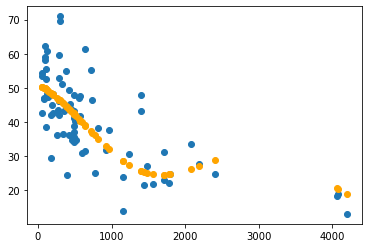

In [210]:
s = train_x.std()
print(f's = {s}')
mu = [500,1500,2500,3500]
print(f'μ = {mu}')

w = gaussian_basis(train_x, train_y, s, mu)
test_x_gaussian_phi = gaussian_phi(test_x, s, mu)
predict_y = np.dot(test_x_gaussian_phi, w)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(test_x, test_y)
ax.scatter(test_x, predict_y,c='orange')

### Model Ealuation by RMSE
$$
RMSE = \sqrt{\frac{\sum(y_n - \hat{y}_n)^2}{n}}
$$
The value of RMSE (= 8.85) was obtained by：

In [211]:
test_size = df_size - train_size
RMSE = np.sqrt( ((test_y - predict_y)**2).sum() / test_size )
print(f'RMSE = {RMSE}')

RMSE = 8.851352568509279


## Consideration
The non-linear Gaussian basis function model was more accurate than the linear model, as expected.